### **Data preprocessing**

&rarr; Have a overview of the data <br>
&rarr; Create the dataset

In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import ants

from IPython.display import display
from numpy.lib.format import open_memmap
from skimage.util import montage

sys.path.append('..')
import Modules.utils as utils
import Modules.init as init
import Modules.display as disp
import Modules.filters as fil

from skimage import exposure
from skimage.exposure import match_histograms
from skimage.filters.rank import median
from skimage.morphology import ball
from skimage.filters import unsharp_mask
from skimage.util import img_as_ubyte

%matplotlib widget

datasets_dir = init.init('Preprocessing')
output_dir = "/user/lcorcos/home/Desktop/MRI_Project/DataPy"

<br>**ATHENA - MRI Segmentation - Preprocessing**

Version              : 1.0
Notebook id          : Preprocessing
Run time             : Wednesday 08 June 2022, 11:01:59
Hostname             : eire (Linux)
Tensorflow log level : Info + Warning + Error (=0)
Datasets dir         : /user/lcorcos/home/Desktop/MRI_Project/Data/
Run dir              : ./run
Update keras cache   : False
numpy                : 1.22.3
sklearn              : 1.0.2
skimage              : 0.19.2
matplotlib           : 3.5.1
plotly               : 5.8.0
pandas               : 1.4.2
nibabel              : 3.2.2


**Visualization of an example**

In [ ]:
nii_img = nib.load('/user/lcorcos/home/Desktop/MRI_Project/DataPy/T2w_acpc_dc_restore.nii.gz')
nii_data = nii_img.get_fdata()
# nii_data = np.rot90(nii_data, 1, axes=(0,2))

In [ ]:
# fig, ax1 = plt.subplots(1, 1, figsize = (20, 20))
# ax1.imshow(montage(nii_data), cmap ='gray')
# #fig.savefig('run/ct_scan.png')
# plt.show()

view = disp.displayMRI(nii_img, "T1")
view

In [ ]:
# Noisy mask
# mask = np.zeros([260, 311, 260, 3], dtype=np.uint8)
# mask[:,:,:] = np.random.randint(0, 100, size=(260, 311, 260,3))

# disp.displayMRIplotMask(nii_data, mask, 100, slider = True, title = '')
disp.displayMRIplot(nii_data, 100, True, "Norm")

#### **T1 modal image processing**

In [ ]:
nii_img = nib.load(f'{datasets_dir}Origin/100206/T1w/T1w_acpc_dc_restore.nii.gz')
nii_data = nii_img.get_fdata()
nii_data = np.rot90(nii_data, 1, axes=(0,2))

# Remove background
nii_data_rem_back = fil.removeBackground(nii_data, '/T1w/T1w_acpc_dc_restore.nii.gz')

# Rescale image intensity
nii_data_rescale = exposure.rescale_intensity(nii_data_rem_back)

# Edge improvement
nii_data_edge = unsharp_mask(nii_data_rescale, radius=1, amount=1)

# Histogram equalization
nii_equal_hist = exposure.equalize_hist(nii_data_edge)

# Data normalization
nii_data_norm = utils.NormalizeData(nii_equal_hist)

# Convert type
nii_equal_hist = img_as_ubyte(nii_equal_hist)

# median filter
smooth_nii = median(nii_equal_hist, ball(1.5))

# Display
disp.displayMRIplot(nii_data, 140, True, "Original image")
disp.displayMRIplot(smooth_nii, 140, True, "Final image")

#### **T2 modal image processing**

In [ ]:
nii_img = nib.load(f'{datasets_dir}Origin/100206/T1w/T2w_acpc_dc_restore.nii.gz')
nii_data = nii_img.get_fdata()
nii_data = np.rot90(nii_data, 1, axes=(0,2))

# Remove background
nii_data_rem_back = fil.removeBackground(nii_data, '/T1w/T2w_acpc_dc_restore.nii.gz')

# Rescale image intensity
nii_data_rescale = exposure.rescale_intensity(nii_data_rem_back)

# Logarithmic correction 
log_corrected = exposure.adjust_log(nii_data_rescale, 1.5)

# Edge improvement
nii_data_edge = unsharp_mask(log_corrected, radius=0.5, amount=0.5)

# Data normalization
nii_data_norm = utils.NormalizeData(nii_data_edge)

# Convert type
nii_data_norm = img_as_ubyte(nii_data_norm)

# Median filter
smooth_nii = median(nii_data_norm, ball(1.7))

# Display
disp.displayMRIplot(nii_data, 140, True, "Original image")
disp.displayMRIplot(smooth_nii, 140, True, "Final image")

#### **Compare result on processed data**

In [3]:
%matplotlib inline

subjects = ['100307', '101410']
files = ['T1w_acpc_dc_restore.nii.gz', 'T2w_acpc_dc_restore.nii.gz']
treatment = ['Origin', 'Rem_Background', 'Best_Color']

In [ ]:
for sub in subjects:
    for file in files:
        for t in treatment:
            nii_to_comp = nib.load(os.path.join(datasets_dir, t, sub, 'T1w', file))
            nii_to_comp_data = nii_to_comp.get_fdata()
            disp.montageSix(nii_to_comp_data, sub + ' - ' + file + ' - ' +t)

#### **Histogram matching**

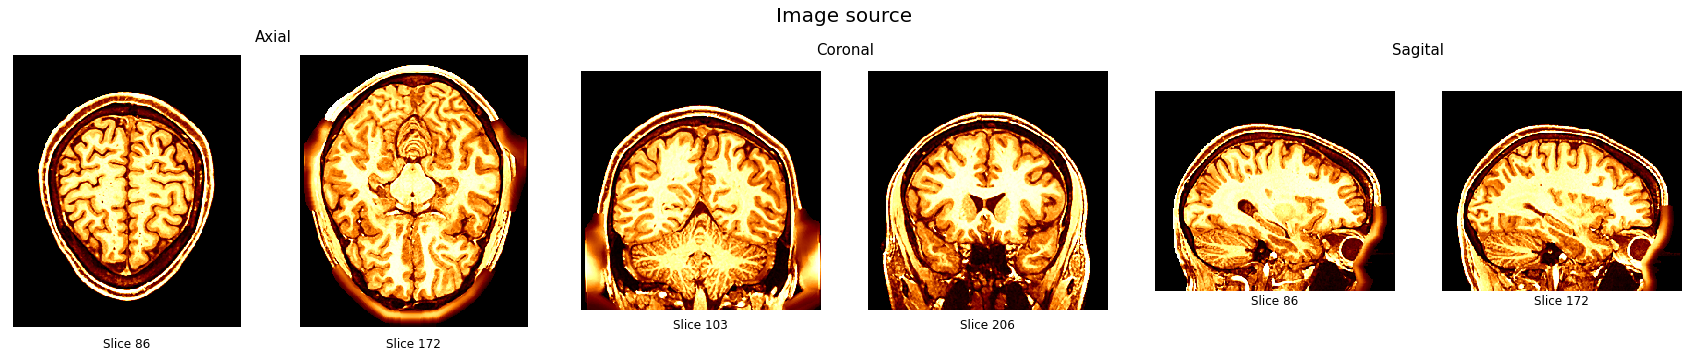

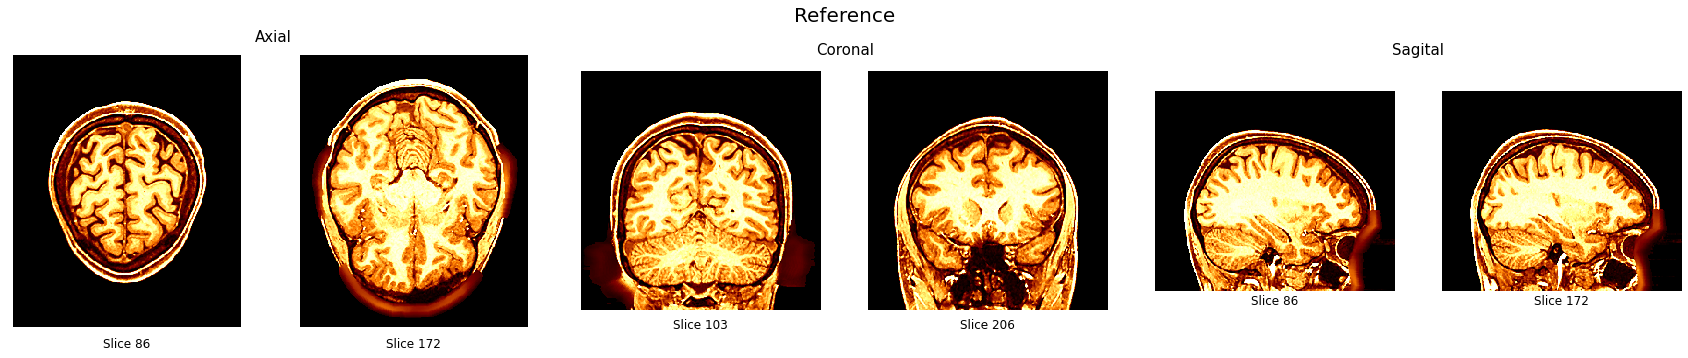

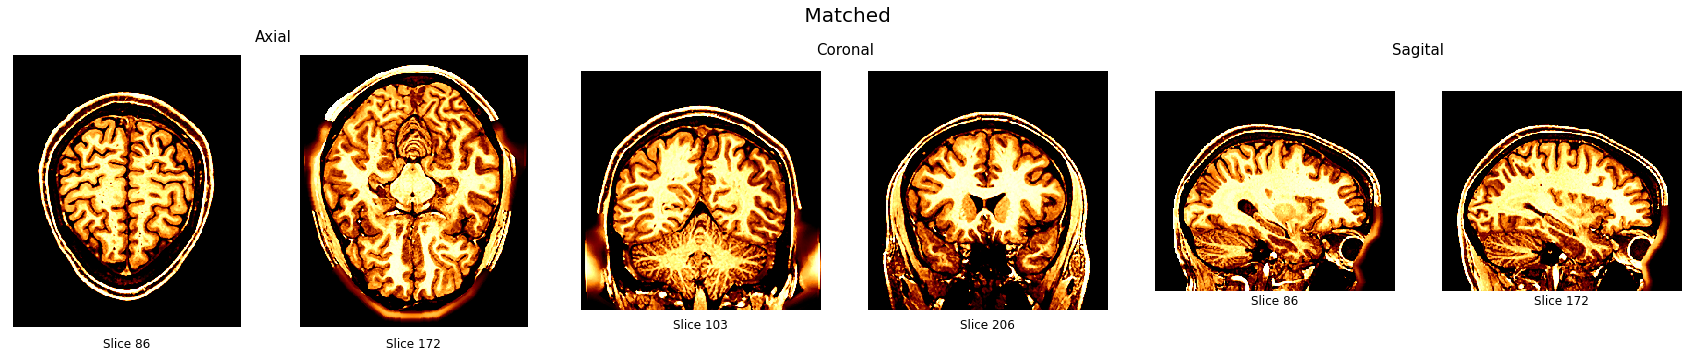

In [7]:
reference = nib.load(os.path.join(datasets_dir, treatment[2], subjects[0], 'T1w', files[0])).get_fdata()
image = nib.load(os.path.join(datasets_dir, treatment[2], subjects[1], 'T1w', files[0])).get_fdata()

matched = match_histograms(image, reference)

disp.compareThree(image, 'Image source', reference, 'Reference', matched, ' Matched')

#### **Registration**

In [4]:
img_source = os.path.join(datasets_dir, treatment[2], subjects[0], 'T1w', files[0])
img_to_register = os.path.join(datasets_dir, treatment[2], subjects[1], 'T1w', files[0])

In [5]:
ants_img_source = ants.image_read(img_source)
ants_img_to_register = ants.image_read(img_to_register)

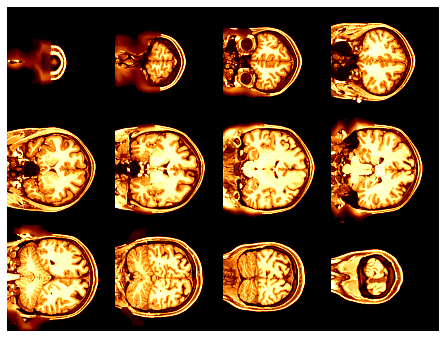

In [6]:
ants.plot(ants_img_source, axis=1, cmap='afmhot', ncol=4)

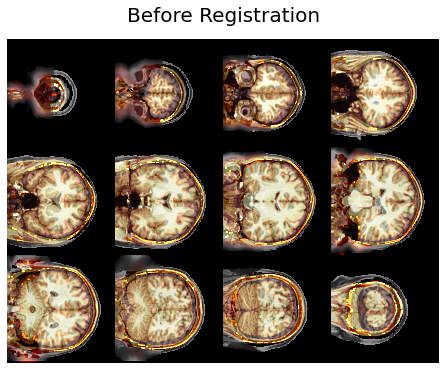

{'warpedmovout': ANTsImage (RPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (260, 311, 260)
	 Spacing    : (0.7, 0.7, 0.7)
	 Origin     : (-90.0, 126.0, -72.0)
	 Direction  : [ 1.  0.  0.  0. -1.  0.  0.  0.  1.]
, 'warpedfixout': ANTsImage (RPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (260, 311, 260)
	 Spacing    : (0.7, 0.7, 0.7)
	 Origin     : (-90.0, 126.0, -72.0)
	 Direction  : [ 1.  0.  0.  0. -1.  0.  0.  0.  1.]
, 'fwdtransforms': ['/user/lcorcos/home/Desktop/MRI_Project/mri-segmentation/Project/run/mat_transform.mat0GenericAffine.mat'], 'invtransforms': ['/user/lcorcos/home/Desktop/MRI_Project/mri-segmentation/Project/run/mat_transform.mat0GenericAffine.mat']}


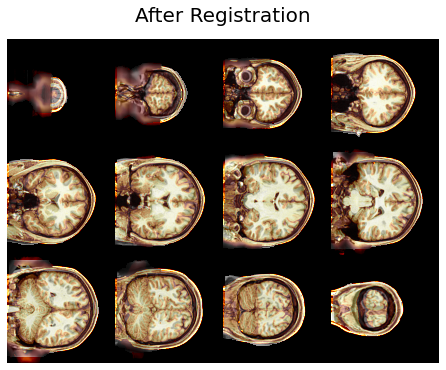

In [7]:
ants_img_source.plot(overlay=ants_img_to_register, 
                     overlay_cmap='gray', 
                     overlay_alpha=0.6, 
                     title='Before Registration', 
                     cmap='afmhot', 
                     axis=1, ncol=4)

mat_transform = ants.registration(fixed=ants_img_source,
                                  moving=ants_img_to_register,
                                  type_of_transform='Affine', 
                                  outprefix = "/user/lcorcos/home/Desktop/MRI_Project/mri-segmentation/Project/run/mat_transform.mat")

print(mat_transform)

warped_moving = mat_transform['warpedmovout']

ants_img_source.plot(overlay=warped_moving,
                     overlay_cmap='gray', 
                     overlay_alpha=0.6, 
                     title='After Registration', 
                     cmap='afmhot',
                     axis=1, ncol=4)

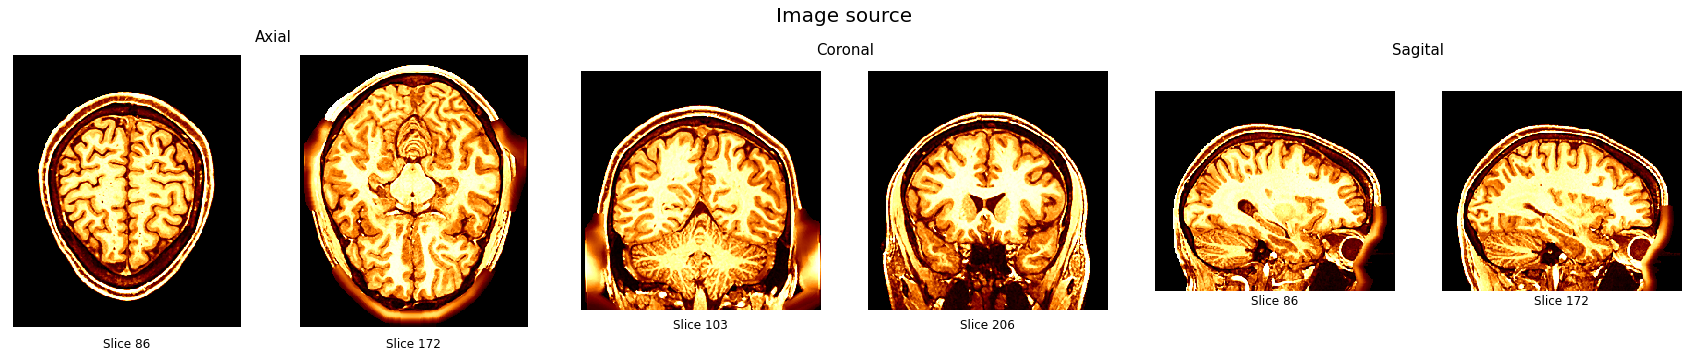

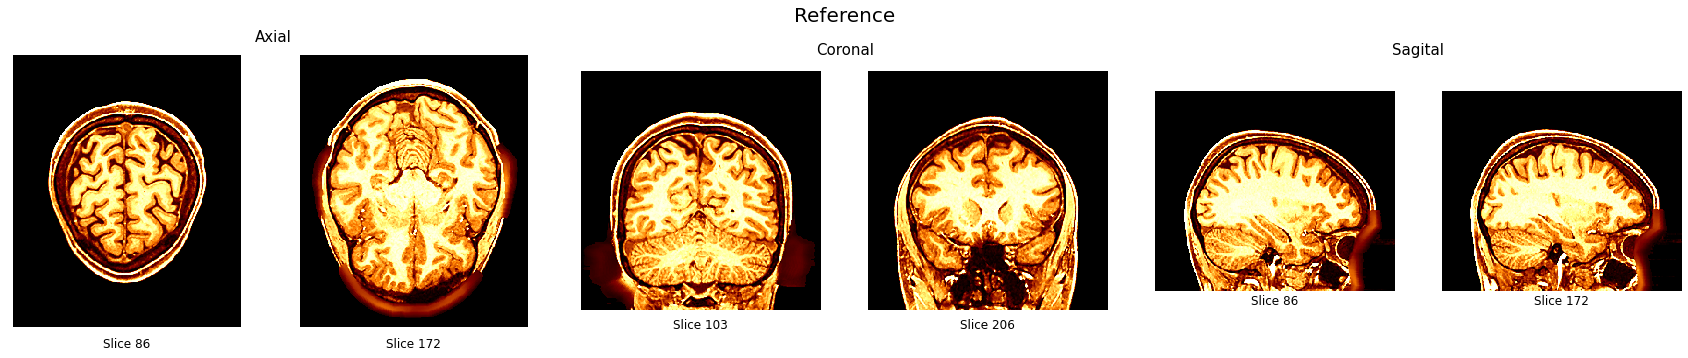

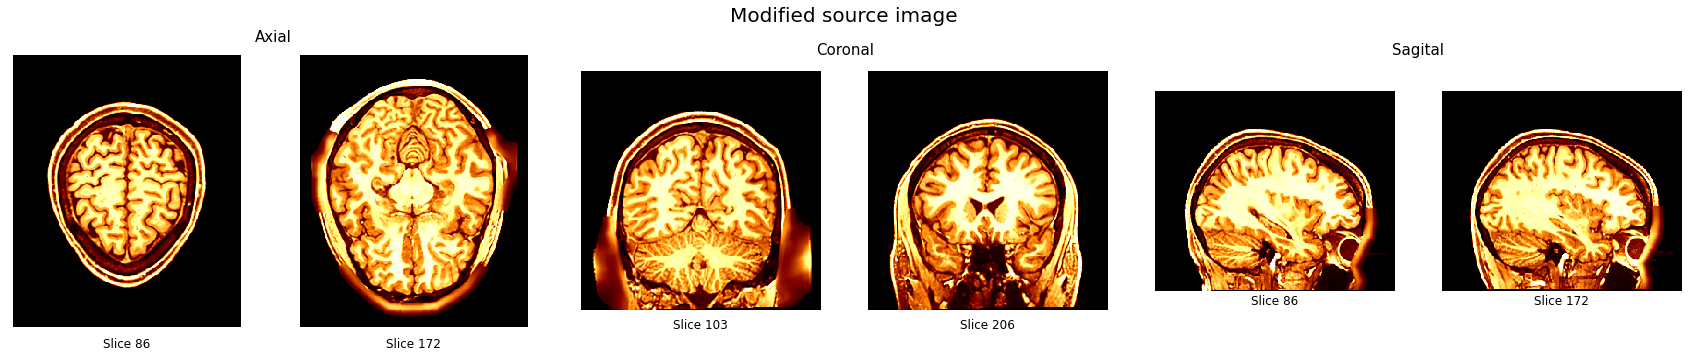

In [8]:
disp.compareThree(ants_img_to_register, 'Image source', ants_img_source, 'Reference', warped_moving, 'Modified source image')

In [10]:
print(ants_img_to_register.shape)
print(ants_img_source.shape)
print(warped_moving.shape)

(260, 311, 260)
(260, 311, 260)
(260, 311, 260)
